In [1]:
from external.pyFIS import pyFIS
import logging
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import numpy as np

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Get data

In [3]:
# Connect to FIS
FIS = pyFIS()

In [4]:
# Create full export of FIS
# outputdir = Path(f'Export_{FIS.geogeneration}')
# outputdir.mkdir(exist_ok=True)
# FIS.export(outputdir / 'export.csv')

In [5]:
# List all geotypes
# FIS.list_geotypes()

In [6]:
# Get all section (=vaarwegvakken) and sectionnodes
section = FIS.list_objects('section')  #.set_index('Id') 
maximumdimensions = FIS.list_objects('maximumdimensions')  #.set_index('Id')
navigability = FIS.list_objects('navigability')  #.set_index('Id')

maximumdimensions_columns = ['geometry', 'GeneralDepth', 'GeneralLength', 'GeneralWidth', 'Note',
       'SeaFairingDepth', 'PushedLength',
       'PushedWidth', 'GeneralHeight', 'SeaFairingLength', 'SeaFairingWidth',
       'CoupledLength', 'CoupledWidth', 'PushedDepth', 'WidePushedDepth',
       'CoupledDepth', 'WidePushedLength', 'WidePushedWidth',
       'SeaFairingHeight']

navigability_columns = ['geometry', 'Classification', 'Code', 'Description']


section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_maximumdimensions'))
section = section.merge(navigability[navigability_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_navigability'))


Removing 4 nan-geometries from dataset


In [7]:
# Remove sections that do not have an ID as start or end point (in the selection polygon this is only the end of the Linge)
# Alternative: Make up new node names for these locations and also add those locations to the section_node table
section = section[~section[['StartJunctionId', 'EndJunctionId']].isna().any(axis=1)]

In [8]:
section_node = FIS.list_objects('sectionjunction').set_index('Id')

In [9]:
b = FIS.merge_geotypes('bridge', 'opening')

In [10]:
# Get all bridges including openings
bridges = FIS.merge_geotypes('bridge', 'opening')

# Get all locks including chambesr
locks = FIS.merge_geotypes('lock', 'chamber')

In [12]:
# Draw polygon on http://geojson.io
extend_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              6.258087158203125,
              51.78058599210829
            ],
            [
              6.28692626953125,
              51.88157756189443
            ],
            [
              6.04522705078125,
              51.91547346517476
            ],
            [
              5.906524658203125,
              51.91547346517476
            ],
            [
              5.58380126953125,
              51.922249577310254
            ],
            [
              5.458831787109375,
              51.926484128050625
            ],
            [
              5.2239990234375,
              51.890053935216926
            ],
            [
              4.99053955078125,
              51.87733877579231
            ],
            [
              4.735107421875,
              51.876490970614775
            ],
            [
              4.577178955078124,
              51.94087861255871
            ],
            [
              4.33135986328125,
              51.96288477548509
            ],
            [
              4.063568115234375,
              52.040666043171306
            ],
            [
              3.8218688964843746,
              51.96203858429277
            ],
            [
              3.967437744140625,
              51.86970795368951
            ],
            [
              4.104766845703125,
              51.89090148463458
            ],
            [
              4.29290771484375,
              51.818802709382474
            ],
            [
              4.450836181640625,
              51.792479108773435
            ],
            [
              4.577178955078124,
              51.77123920059797
            ],
            [
              4.59503173828125,
              51.66403781658121
            ],
            [
              4.747467041015625,
              51.66403781658121
            ],
            [
              4.8662567138671875,
              51.764865278196844
            ],
            [
              5.306396484375,
              51.77888671946537
            ],
            [
              5.3510284423828125,
              51.79078028408291
            ],
            [
              5.4169464111328125,
              51.84044447205223
            ],
            [
              5.5268096923828125,
              51.86419599905765
            ],
            [
              5.7932281494140625,
              51.818802709382474
            ],
            [
              6.0074615478515625,
              51.815831459725224
            ],
            [
              6.258087158203125,
              51.78058599210829
            ]
          ]
        ]
      }
    }
  ]
}

In [13]:
# Create selection for processing
extend_polygon = Polygon(extend_geojson['features'][0]['geometry']['coordinates'][0])
section_selection = section[section.geometry.within(extend_polygon)].copy()
bridges_selection = bridges[bridges.geometry.within(extend_polygon)].copy()
locks_selection = locks[locks.geometry.within(extend_polygon)].copy()

In [14]:
def group_subobjects(bridges_selection, fieldname=None, type_selection='max'):

    if fieldname is not None:
        # Remove nans
        bridges_selection = bridges_selection[~bridges_selection[fieldname].isna()]

    # Only keep opening with the maximum HeightClosed
    if type_selection=='max':
        id_max_height = bridges_selection.groupby('Id')[fieldname].idxmax().values

        bridges_selection = bridges_selection.reindex(id_max_height)
        bridges_selection = bridges_selection.set_index('Id')
    else:
        print('Unknown criteria')
    return bridges_selection

bridges_selection_grouped = group_subobjects(bridges_selection, fieldname='HeightClosed')
locks_selection_grouped = group_subobjects(locks_selection, fieldname='Id')

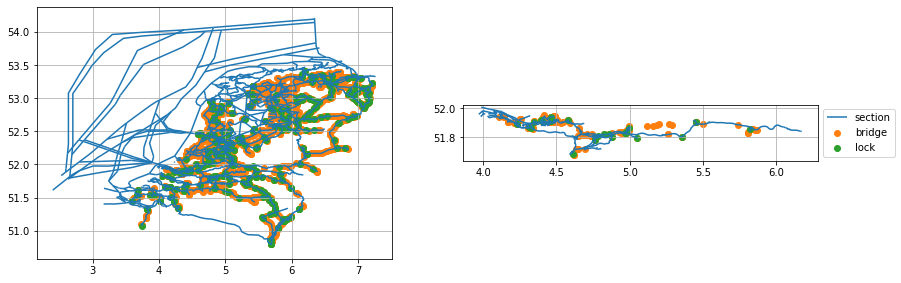

In [15]:
f, ax  = plt.subplots(figsize=(14,10), ncols=2)
section.plot(color='C0', ax=ax[0])
bridges.plot(c='C1', ax=ax[0])
locks.plot(c='C2', ax=ax[0])
ax[0].grid()

section_selection.plot(color='C0', ax=ax[1], label='section')
bridges_selection_grouped.plot(c='C1', ax=ax[1], label='bridge')
locks_selection_grouped.plot(c='C2', ax=ax[1], label='lock')
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Build network

In [16]:
section_selection['length'] = section_selection.length.values
network = nx.from_pandas_edgelist(section_selection, 'StartJunctionId', 'EndJunctionId', edge_attr=True)

In [17]:
# Add node properties
for n in network.nodes:
    network.node[n]['X'] = section_node.loc[n].geometry.x
    network.node[n]['Y'] = section_node.loc[n].geometry.y

D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(3.8557831336784436, 6.288781878601294, 51.65480999171159, 52.027390959010205)

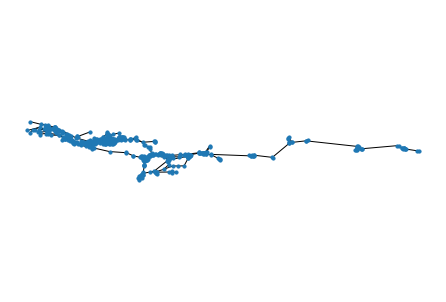

In [18]:
nx.draw(network, 
        pos={k: (v['X'], v['Y']) for k, v in network.node.items()}, 
        node_size=10)
plt.gca().axis('equal')

# Now add bridges as nodes

I'm not sure if this was really necessary...

In [19]:
# Splitting the closest line at given point

def nearest_line(point, lines):
    # Returns index of the closest line to the point
    # point: Shapely Point
    # lines: Shapely Polylines
    d = np.full((len(lines)), fill_value=np.nan)
    for ii in range(len(lines)):
        d[ii] = point.distance(lines[ii])
    return np.argmin(d), np.min(d)

def chainage_on_line(point, line):
    # Find chainage of line closest to point
    # point: Shapely Point
    # lines: Shapely Polylines
    return line.project(point)
    
def cut(line, chainage):
    # Cuts a line in two at a distance from its starting point
    # point: Shapely Polyline
    # chainage: distance along line
    
    # if 0 or longer than line, return line
    if chainage <= 0.0 or chainage >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == chainage:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > chainage:
            cp = line.interpolate(chainage)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]


# Example data
# ls1 = LineString([(0,0), (4,4), (5,2)])
# ls2 = LineString([(0,0), (4, 0), (6,1)])
# ls = [ls1, ls2]
# p = Point(2,3)
# 
# ii, distance = nearest_line(p, ls)
# c = chainage_on_line(p, ls[ii])
# split = cut(ls[ii], c)

In [22]:
def split_lines_at_points(section_selection, bridges_selection, max_distance=0.002, prefix='B', 
                          node_start_columnname="StartJunctionId", node_end_columnname="EndJunctionId"):
    """
    section_selection: geodataframe of polylines
    bridges_selection: geodataframe of points where you want to polylines to split
    
    max_distance: maximum distance of point to line in order. When max_distance is exceeded, the point will be ignored
    prefix: the nodes will be split get a new of the index of 'bridge_selection' with this prefix
    
    node_start_columnname: in dataframe 'section_selection' name of start_node
    node_end_columnname: in dataframe 'section_selection' name of end_node
    
    """
    
    
    section_selection_with_bridges = section_selection.copy()
    for k, bridge in bridges_selection.iterrows():

        # abreviate
        b = bridge.geometry
        bridge_ID = f'{prefix}{k}'
        s = section_selection_with_bridges.geometry.values

        # Split closest section
        nearest_section, distance_to_nearest_section = nearest_line(b, s)
        if distance_to_nearest_section> max_distance: # If distance (in degree) it too large, apparently it's not near a section
            print(f'Too far from river, ignoring point (name: "{bridge.Name}")')
            continue

        chainage = chainage_on_line(b, s[nearest_section])

        # Chainage already on a node, no need to split
        if chainage == 0 or chainage == s[nearest_section].length:

            # Replace name of node, with name of bridge
            if chainage == 0:
                node_ID = section_selection_with_bridges.iloc[nearest_section][node_start_columnname]
            else:
                node_ID = section_selection_with_bridges.iloc[nearest_section][node_end_columnname]

            print(f'Renaming node {node_ID} to point {bridge_ID} (name: "{bridge.Name}")')
            section_selection_with_bridges[[node_start_columnname, node_end_columnname]] = section_selection_with_bridges[[node_start_columnname, node_end_columnname]].replace({node_ID: bridge_ID})
            continue

        split = cut(s[nearest_section], chainage)


        # Create new sections    
        section_old = section_selection_with_bridges.iloc[nearest_section]

        section_new_1 = section_old.copy()
        section_new_2 = section_old.copy()

        section_new_1['geometry'] = split[0]
        section_new_2['geometry'] = split[1]


        section_new_1[node_end_columnname] = bridge_ID
        section_new_2[node_start_columnname] = bridge_ID

        section_new_1.name = f'{section_old.name}_A'
        section_new_2.name = f'{section_old.name}_B'

        # Update DataFrame
        section_selection_with_bridges = section_selection_with_bridges.drop(section_old.name, axis='index')
        section_selection_with_bridges = section_selection_with_bridges.append(section_new_1)
        section_selection_with_bridges = section_selection_with_bridges.append(section_new_2)
    return section_selection_with_bridges


In [23]:
section_selection_with_bridges = split_lines_at_points(section_selection, bridges_selection_grouped)
section_selection_with_bridges_with_locks = split_lines_at_points(section_selection_with_bridges, locks_selection_grouped, prefix='L')

Too far from river, ignoring point (name: "Doenbrug")
Too far from river, ignoring point (name: "brug in de N322 St. Andries")
Too far from river, ignoring point (name: "brug in de A17 Moerdijk")
Renaming node 8861142.0 to point B15331 (name: "Roodevaartbrug ")
Too far from river, ignoring point (name: "spoorbrug Nijmegen (Maas-Waalkanaaal)")
Too far from river, ignoring point (name: "Neerbossche brug")
Too far from river, ignoring point (name: "Beesd, brug in de A-2")
Too far from river, ignoring point (name: "spoorbrug Geldermalsen")
Too far from river, ignoring point (name: "Lingesluis, brug")
Too far from river, ignoring point (name: "Graafse brug")
Too far from river, ignoring point (name: "spoorbrug Arkel")
Too far from river, ignoring point (name: "spoorbrug Moerdijk (Roode Vaart)")
Too far from river, ignoring point (name: "Geldermalsen, brug in de N-833")
Too far from river, ignoring point (name: "Philips Willembrug")
Too far from river, ignoring point (name: "Heersdijkbrug")


In [24]:
def build_network(section_selection_with_bridges_with_locks):
    section_selection_with_bridges_with_locks['length'] = section_selection_with_bridges_with_locks.length.values
    section_selection_with_bridges_with_locks['Wkt'] = [a.wkt for a in section_selection_with_bridges_with_locks.geometry]
    section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.drop('geometry', axis=1)
    
    network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'StartJunctionId', 'EndJunctionId', edge_attr=True)
    
    # Shorten names in case of shapefile export
#     section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.rename(columns={'StartJunctionId': 'Start', 'EndJunctionId': 'End'})
#     network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'Start', 'End', edge_attr=True)
    return network

network = build_network(section_selection_with_bridges_with_locks)
# network = build_network(section_selection_with_bridges_with_locks[['geometry', 'StartJunctionId', 'EndJunctionId']])

In [25]:
def add_node_properties(network, gpd_nodes):
    for prefix, gpd in gpd_nodes.items():
        a = gpd.geometry.copy()
        if len(prefix):
            a.index = [f'{prefix}{b}' for b in a.index]
        
        nx.set_node_attributes(network, {k: v.wkt for k, v in a.to_dict().items()}, 'Wkt')
        nx.set_node_attributes(network, {k: v.x for k, v in a.to_dict().items()}, 'x')
        nx.set_node_attributes(network, {k: v.y for k, v in a.to_dict().items()}, 'y')
        

add_node_properties(network, {
    '': section_node,
    'B': bridges_selection_grouped,
    'L': locks_selection_grouped
})



In [47]:
# network.get_edge_data(*(8866014.0, 8862473.0))

In [26]:
# nx.write_shp(network, '.')  # Names too long for shapefiles
nx.write_yaml(network, 'result/export_corridor.yaml')
nx.write_gml(network, 'result/export_corridor.gml')

In [43]:
network = nx.read_yaml('result/export_corridor.yaml')

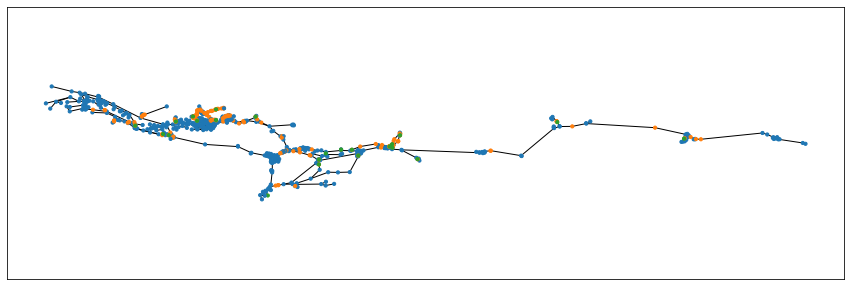

In [51]:
node_colors = {'B': 'C1', 'L': 'C2'}
plt.subplots(figsize=(15,5))
nx.draw_networkx(network, 
                 pos={k: (v['x'], v['y']) for k, v in network.node.items()}, 
                 node_color=[node_colors.get(str(k)[:1], 'C0') for k in network.node],
                 with_labels=False,
                 node_size=10)
plt.gca().axis('equal')
plt.savefig('result/export_corridor.png')

# Apply full scale

In [ ]:
bridges_grouped = group_subobjects(bridges, fieldname='HeightClosed')
locks_grouped = group_subobjects(locks, fieldname='Id')

section_with_bridges = split_lines_at_points(section, bridges_grouped)
section_with_bridges_locks = split_lines_at_points(section_with_bridges, locks_grouped)

network = build_network(section_with_bridges_locks)
network = add_node_properties(network, bridges_grouped, locks_grouped)

node_colors = {'B': 'C1', 'L': 'C2'}

In [29]:
nx.write_yaml(network, 'result/export_full_network.yaml')
nx.write_gml(network, 'result/export_full_network.gml')

In [ ]:
nx.draw_networkx(network, 
                 pos={k: (v['x'], v['y']) for k, v in network.node.items()}, 
                 node_color=[node_colors.get(str(k)[:1], 'C0') for k in network.node],
                 with_labels=False,
                 node_size=10)
plt.gca().axis('equal')